# Calculates Pearson's correlation between markers in selected cells

In [1]:
import os
import glob
import sys
from pathlib import Path 
from math import log10, sqrt, ceil, floor, log, exp, pi, isnan
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=44)
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmapy
import tifffile
import pandas as pd
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.signal import convolve2d
import seaborn as sns
from tqdm.notebook import tqdm, trange
from skimage import color
from skimage.transform import rescale
from skimage.util import view_as_windows
import skimage
import skimage.filters
import scipy
import pickle
import time

import multiprocessing as mp
from multiprocessing import Process, Queue, Value, Array, Pool

import matplotlib.font_manager as fm
%matplotlib inline
%gui qt5

In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
os.chdir('..')
os.chdir('./src')

In [4]:
from my_io import display_list_image, read_tiff_files
from colocalization import generate_pearson_metric_masked
from config import *

In [5]:
pickle_name_temp = f"{data_path_masked_BM}/image_list_BM.pickle"
zoomed_image_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/image_list_UC.pickle"
zoomed_image_list_UC = pickle.load(open(pickle_name_temp, "rb"))

In [6]:
# Figures location
save_path = f"{data_figure}/colocalization/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Thresholding

In [7]:
def minMaxScaleThreshold(img, thresh):
    img = np.true_divide(img - np.min(img), \
                        np.zeros_like(img) + np.max(img) - np.min(img))
    img[img < thresh] = 0
    
    return img

# apply threshold
def applyThresholdMethod(img, choice):
    threshVal = 0
    
    if choice == 'Otsu':
        threshVal = skimage.filters.threshold_otsu(img)
        
    elif choice == 'Isodata':
        threshVal = skimage.filters.threshold_isodata(img)
        
    elif choice == 'Li':
        threshVal = skimage.filters.threshold_li(img)
        
    elif choice == 'Mean':
        threshVal = skimage.filters.threshold_mean(img)
        
    elif choice == 'Minimum':
        threshVal = skimage.filters.threshold_minimum(img)
        
    elif choice == 'Triangle':
        threshVal = skimage.filters.threshold_triangle(img)
        
    elif choice == 'Yen':
        threshVal = skimage.filters.threshold_yen(img)
        
    else:
        print('Threshold Method not found...')        
    
    return threshVal

In [8]:
threshChoice = 'Otsu'

### BM cells

In [9]:
metric_array_list_BM = []

for cell in BM_indices:
    metric_array = np.zeros((len(idx_channel_names_modif), len(idx_channel_names_modif)), dtype=np.float64)
    for i_count, i in enumerate(idx_channel_names_modif):
        for j_count, j in enumerate(idx_channel_names_modif):
            image1_temp = zoomed_image_list_BM[cell][i].copy()
            image2_temp = zoomed_image_list_BM[cell][j].copy()
            
            # fig, ax = plt.subplots(dpi = 300)
            # ax.imshow(image1_temp, cmap = 'coolwarm')
            # ax.axis('off')
            
            # do Otsu, Yen, Triangle, thresholding
            threshVal = applyThresholdMethod(image1_temp, choice = threshChoice)
            image1_temp[image1_temp < threshVal] = 0
            threshVal = applyThresholdMethod(image2_temp, choice = threshChoice)
            image2_temp[image2_temp < threshVal] = 0 
            
            # fig, ax = plt.subplots(dpi = 300)
            # ax.imshow(image1_temp, cmap = 'coolwarm')
            # ax.axis('off')
            # sys.exit()
            
            metrics_temp = generate_pearson_metric_masked(image1_temp, image2_temp)
            metric_array[i_count, j_count] = np.array(metrics_temp, dtype=np.float64)
    metric_array_list_BM.append(metric_array)
    
metric_array_mean_BM = np.array(metric_array_list_BM).mean(axis=0)
metric_array_std_BM = np.array(metric_array_list_BM).std(axis=0)

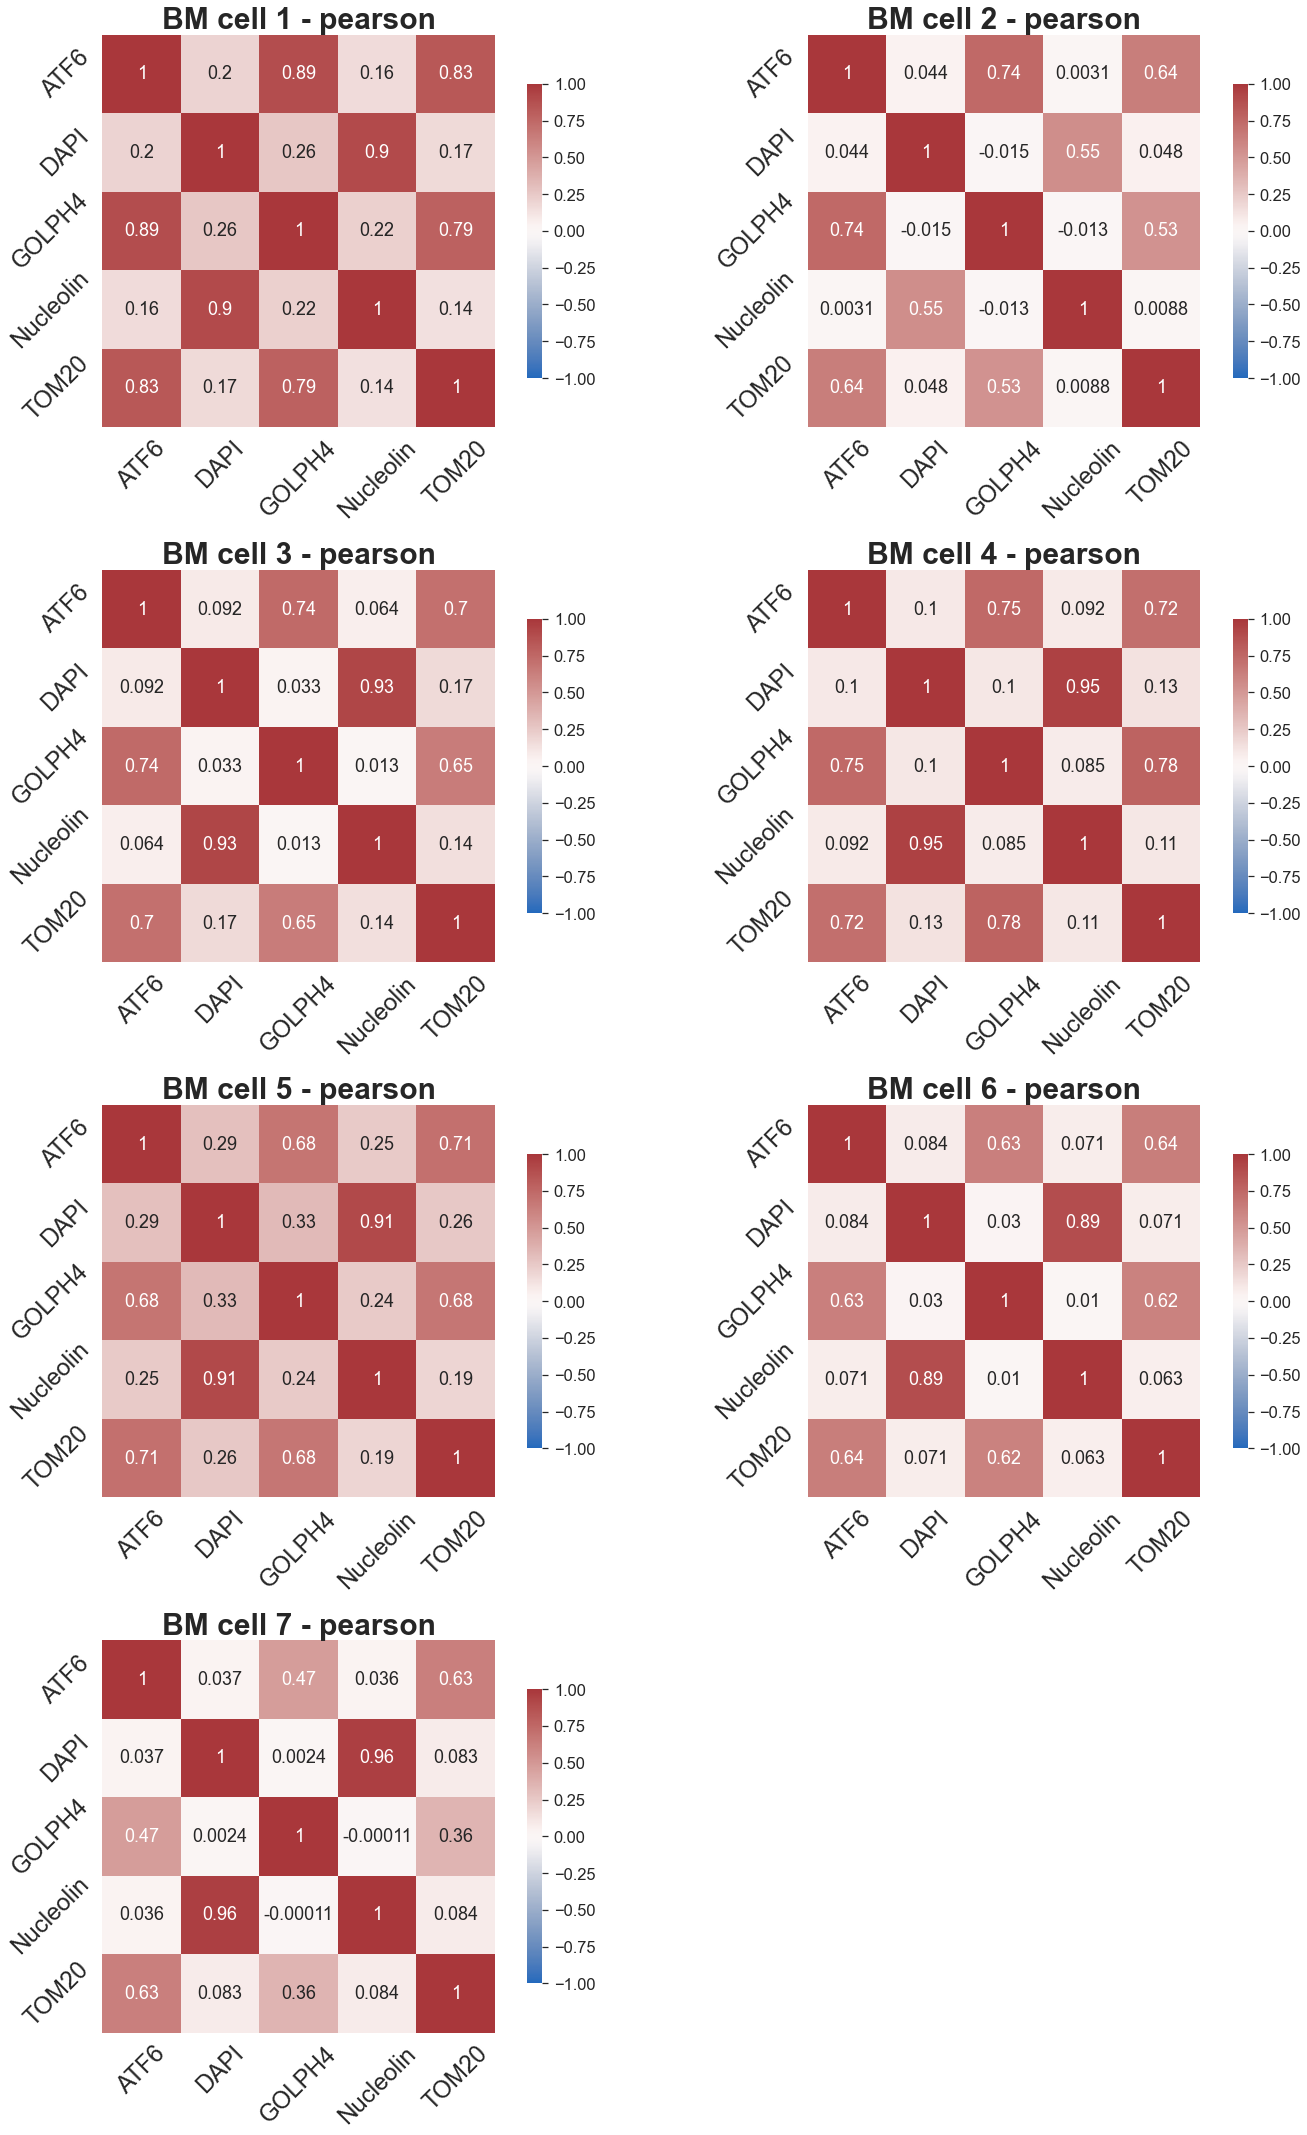

In [10]:
sns.set_style("white")
plt.style.use('seaborn-paper')
range_list = [-1., 1.]

fig, axes = plt.subplots(4, 2, figsize=(20, 30))
sns.set(font_scale=1.5)
tbl = pd.DataFrame()
for cell, ax in zip(range(len(BM_indices)), axes.flatten()):
    ax.set_title(f"BM cell {cell+1} - pearson", fontsize = 30, fontweight ="bold")
    df_mean = pd.DataFrame(metric_array_list_BM[cell], columns=channel_names_modif, index=channel_names_modif)
    g = sns.heatmap(df_mean, vmin=range_list[0], vmax=range_list[1], square=True, cmap='vlag', ax=ax, center=0.00, annot=True, cbar_kws={"shrink": 0.75})   
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 24, rotation=45)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 24, rotation=45)
    
    # format for suppl table
    subTbl = pd.DataFrame()
    for jj, marker1 in enumerate(df_mean.index):
        
        for kk, marker2 in enumerate(df_mean.columns):
                
            if kk > jj: # upper triangle only
                row = {}
                row['BM' + str(cell + 1)] = df_mean.iloc[jj, kk]
                row = pd.DataFrame(row, columns = ['BM' + str(cell + 1)], index = [marker1 + '_' + marker2])
        
                subTbl = pd.concat([subTbl, row])
    
    tbl = tbl.merge(subTbl, how = 'outer', left_index = True, right_index = True)
    
avg = tbl.mean(axis = 1) 
std = tbl.std(axis = 1)
tbl['BM Average'] = avg
tbl['BM StdDev'] = std

# export table to excel
fileOut = os.path.join(save_path, 'pearsons_BM_cells.xlsx')
tbl.to_excel(fileOut)
    
axes[3,1].set_visible(False)

plt.tight_layout()
image_path_png = save_path + "/cell_pearson_BM.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

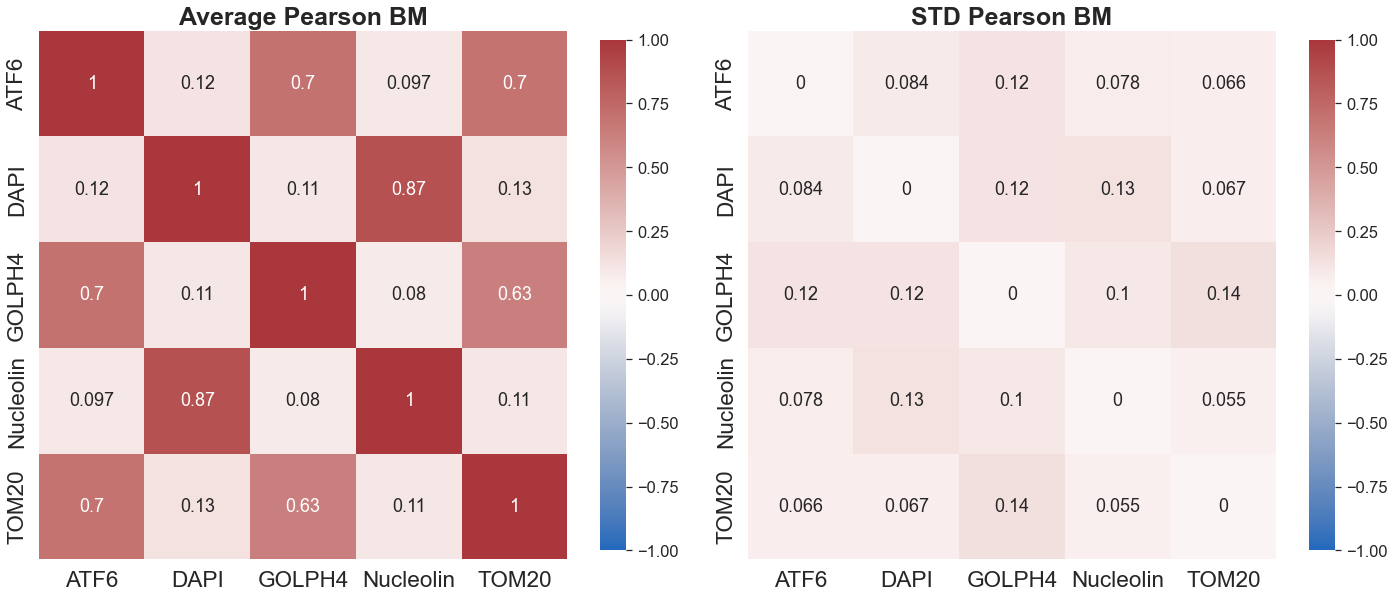

In [11]:
sns.set_style("dark")
range_list = [-1., 1.]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
ax.set_title(f"Average Pearson BM", fontsize = 25, fontweight ="bold")
df_mean = pd.DataFrame(metric_array_mean_BM, columns=channel_names_modif, index=channel_names_modif)
g = sns.heatmap(df_mean, vmin=range_list[0], vmax=range_list[1], square=True, cmap='vlag', ax=ax, center=0.00, annot=True, cbar_kws={"shrink": 0.75})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22.5)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22.5)

ax = axes[1]
ax.set_title(f"STD Pearson BM", fontsize = 25, fontweight ="bold")
df_std = pd.DataFrame(metric_array_std_BM, columns=channel_names_modif, index=channel_names_modif)
g = sns.heatmap(df_std, vmin=range_list[0], vmax=range_list[1], square=True, cmap='vlag', ax=ax, center=0.00, annot=True, cbar_kws={"shrink": 0.75})    
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22.5)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22.5)
    
plt.tight_layout()
image_path_png = save_path + "/average_std_pearson_BM.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

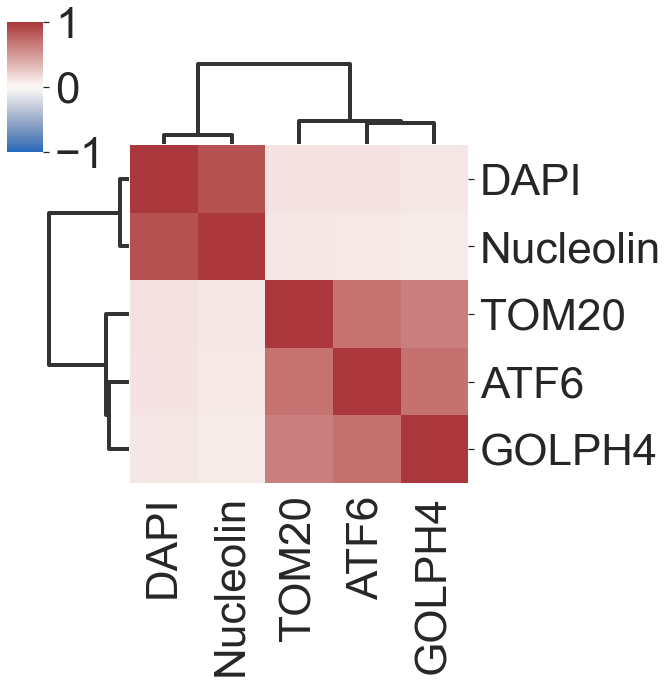

In [12]:
sns.set_style("dark")
range_list = [-1., 1.]
annot = False

df_mean = pd.DataFrame(metric_array_mean_BM, columns=channel_names_modif, index=channel_names_modif)
sns.set(font_scale = 4)
g = sns.clustermap(df_mean, vmin=range_list[0], vmax=range_list[1],  cmap='vlag', annot=annot, cbar_kws={'ticks': [-1, 0, 1]}, \
                  tree_kws=dict(linewidths=4)) 

image_path_png = save_path + "/average_pearson_BM.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

### UC cells

In [13]:
metric_array_list_UC = []

for cell in UC_indices:
    metric_array = np.zeros((len(idx_channel_names_modif), len(idx_channel_names_modif)), dtype=np.float64)
    for i_count, i in enumerate(idx_channel_names_modif):
        for j_count, j in enumerate(idx_channel_names_modif):
            image1_temp = zoomed_image_list_UC[cell][i].copy()
            image2_temp = zoomed_image_list_UC[cell][j].copy()
            
            # do Otsu, Yen, Triangle, thresholding
            threshVal = applyThresholdMethod(image1_temp, choice = threshChoice)
            image1_temp[image1_temp < threshVal] = 0
            threshVal = applyThresholdMethod(image2_temp, choice = threshChoice)
            image2_temp[image2_temp < threshVal] = 0 
            
            metrics_temp = generate_pearson_metric_masked(image1_temp, image2_temp)
            metric_array[i_count, j_count] = np.array(metrics_temp, dtype=np.float64)
    metric_array_list_UC.append(metric_array)
    
metric_array_mean_UC = np.array(metric_array_list_UC).mean(axis=0)
metric_array_std_UC = np.array(metric_array_list_UC).std(axis=0)

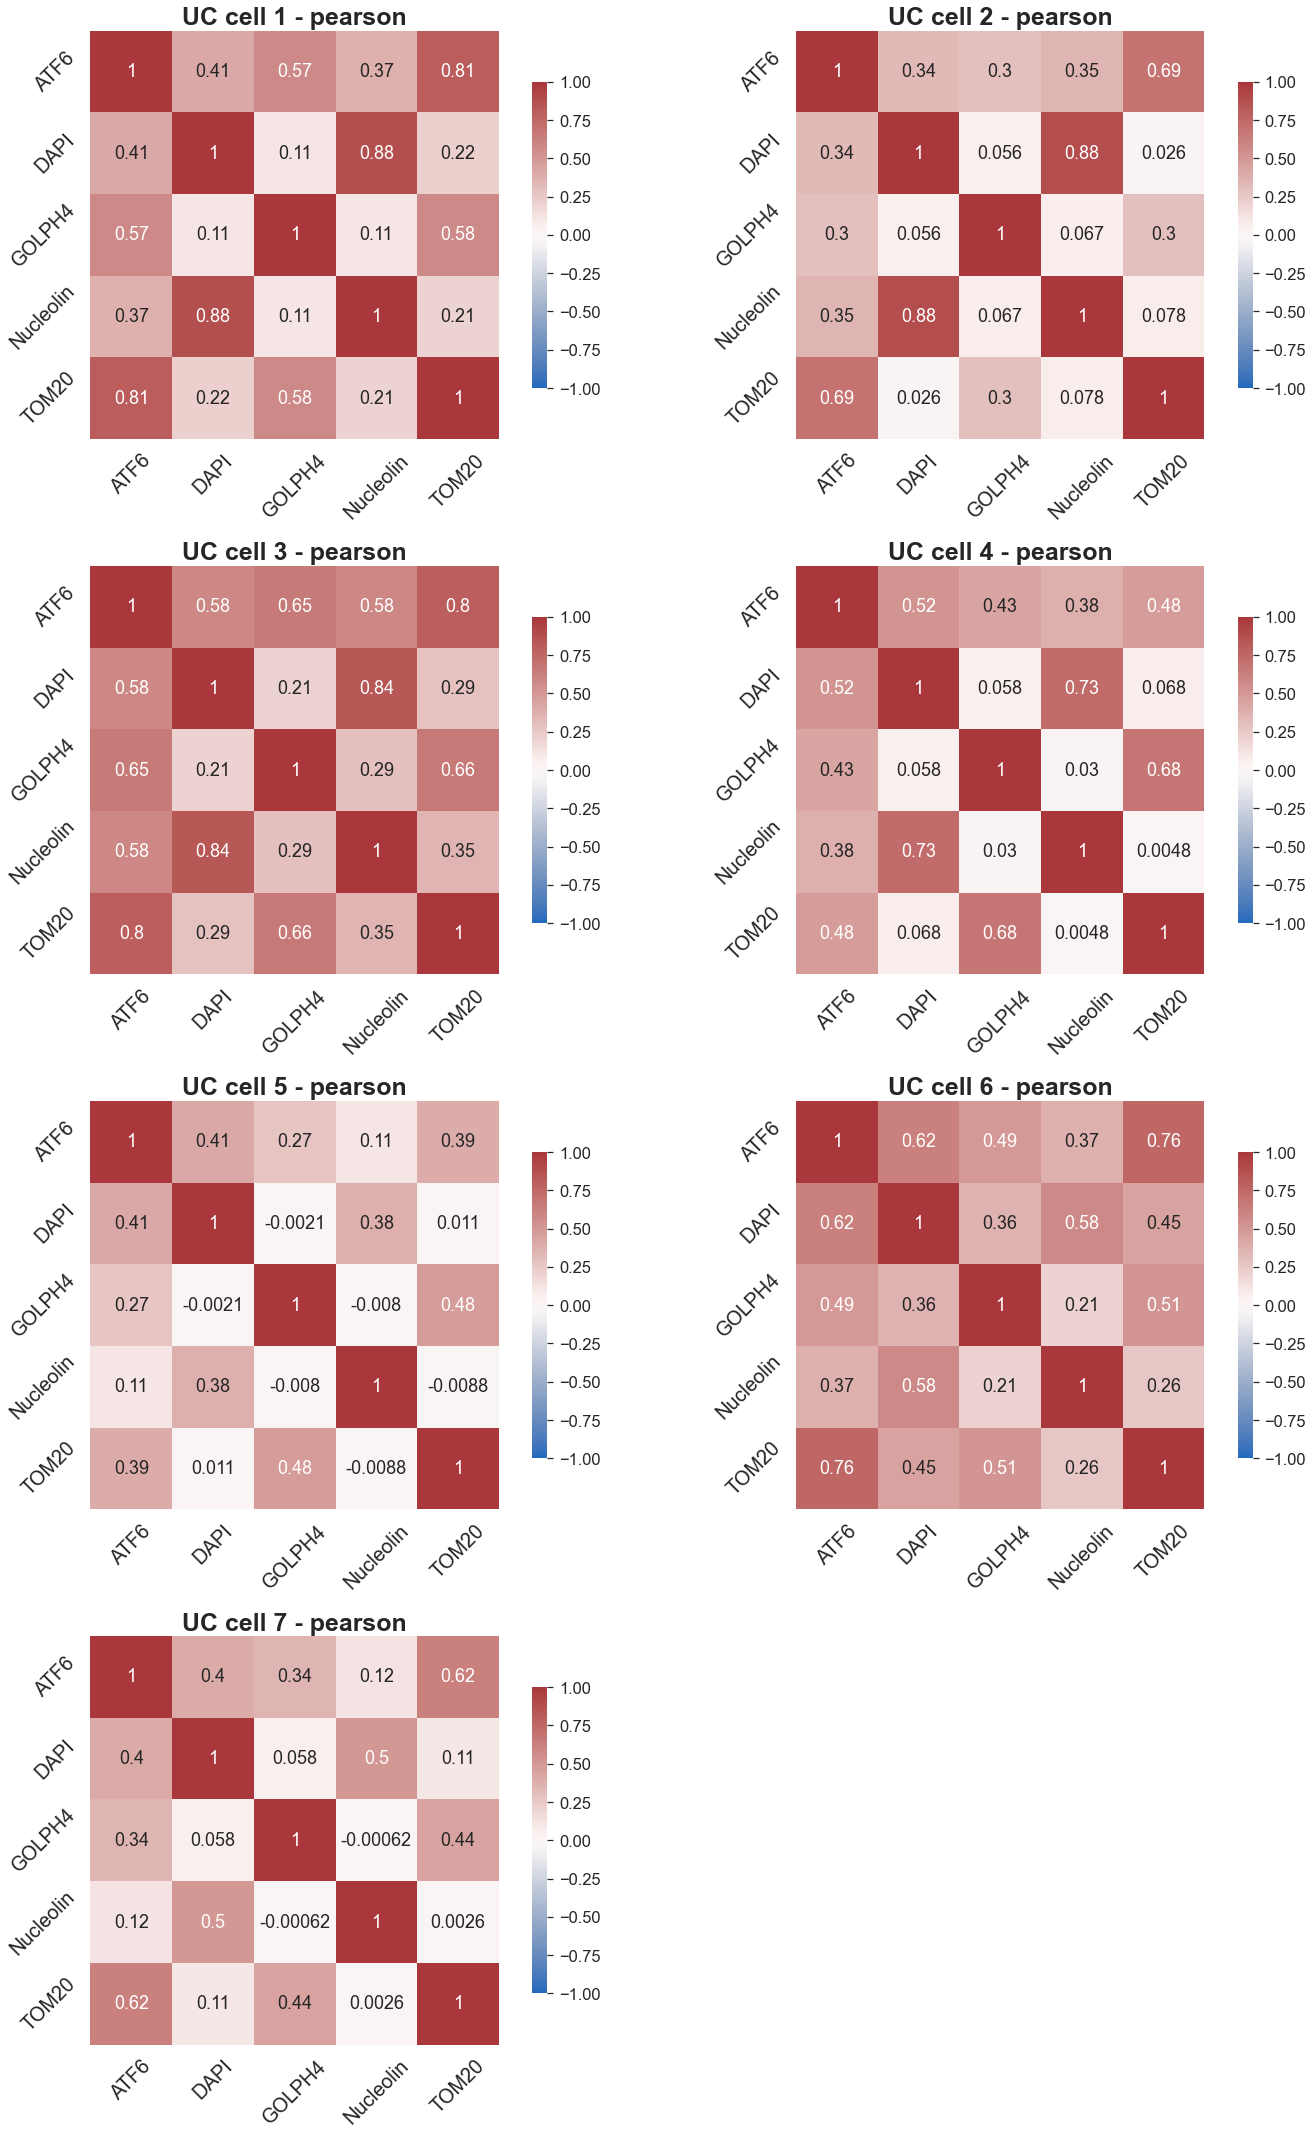

In [14]:
sns.set_style("white")
plt.style.use('seaborn-paper')
range_list = [-1., 1.]

fig, axes = plt.subplots(4, 2, figsize=(20, 30))
sns.set(font_scale=1.5)
tbl = pd.DataFrame()
for cell, ax in zip(range(len(UC_indices)), axes.flatten()):
    ax.set_title(f"UC cell {cell+1} - pearson", fontsize = 25, fontweight ="bold")
    df_mean = pd.DataFrame(metric_array_list_UC[cell], columns=channel_names_modif, index=channel_names_modif)
    g = sns.heatmap(df_mean, vmin=range_list[0], vmax=range_list[1], square=True, cmap='vlag', ax=ax, center=0.00, annot=True, cbar_kws={"shrink": 0.75})   
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 20, rotation=45)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 20, rotation=45)
    
    # format for suppl table
    subTbl = pd.DataFrame()
    for jj, marker1 in enumerate(df_mean.index):
        
        for kk, marker2 in enumerate(df_mean.columns):
                
            if kk > jj: # upper triangle only
                row = {}
                row['UC' + str(cell + 1)] = df_mean.iloc[jj, kk]
                row = pd.DataFrame(row, columns = ['UC' + str(cell + 1)], index = [marker1 + '_' + marker2])
        
                subTbl = pd.concat([subTbl, row])
    
    tbl = tbl.merge(subTbl, how = 'outer', left_index = True, right_index = True)
    
avg = tbl.mean(axis = 1) 
std = tbl.std(axis = 1)
tbl['UC Average'] = avg
tbl['UC StdDev'] = std

# export table to excel
fileOut = os.path.join(save_path, 'pearsons_UC_cells.xlsx')
tbl.to_excel(fileOut)
    
axes[3,1].set_visible(False)

plt.tight_layout()
image_path_png = save_path + "/cell_pearson_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

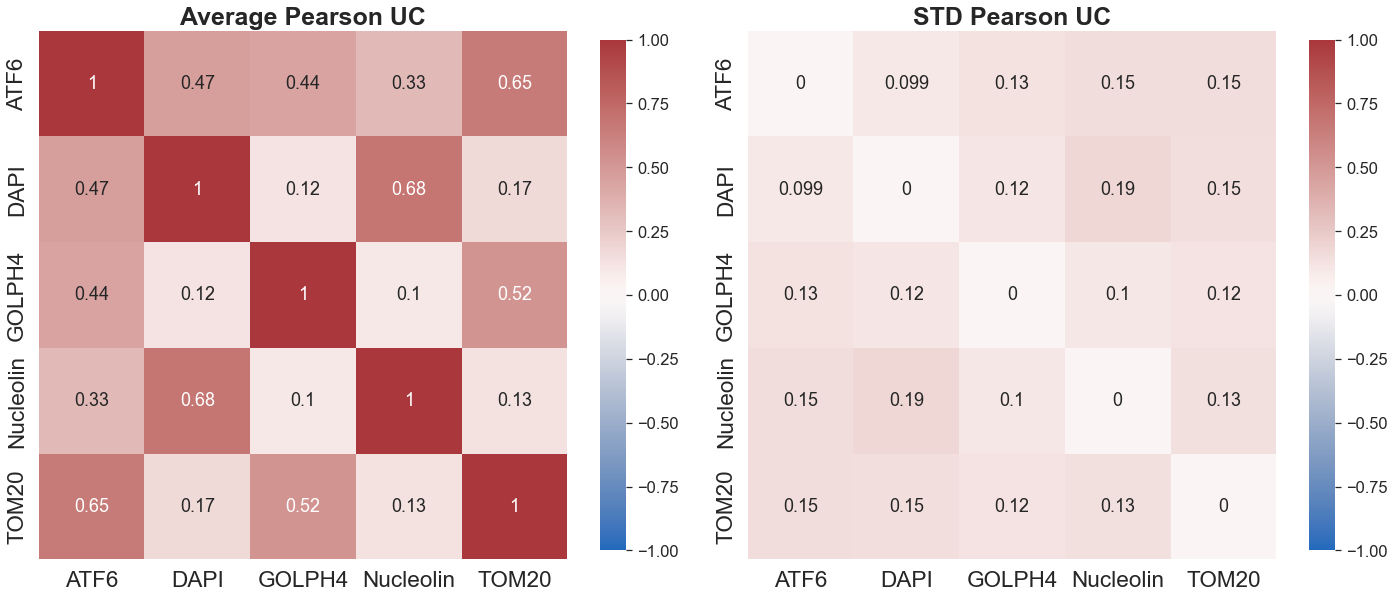

In [15]:
sns.set_style("dark")
range_list = [-1., 1.]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
ax.set_title(f"Average Pearson UC", fontsize = 25, fontweight ="bold")
df_mean = pd.DataFrame(metric_array_mean_UC, columns=channel_names_modif, index=channel_names_modif)
g = sns.heatmap(df_mean, vmin=range_list[0], vmax=range_list[1], square=True, cmap='vlag', ax=ax, center=0.00, annot=True, cbar_kws={"shrink": 0.75})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22.5)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22.5)

ax = axes[1]
ax.set_title(f"STD Pearson UC", fontsize = 25, fontweight ="bold")
df_std = pd.DataFrame(metric_array_std_UC, columns=channel_names_modif, index=channel_names_modif)
g = sns.heatmap(df_std, vmin=range_list[0], vmax=range_list[1], square=True, cmap='vlag', ax=ax, center=0.00, annot=True, cbar_kws={"shrink": 0.75})    
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22.5)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22.5)
    
plt.tight_layout()
image_path_png = save_path + "/average_std_pearson_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

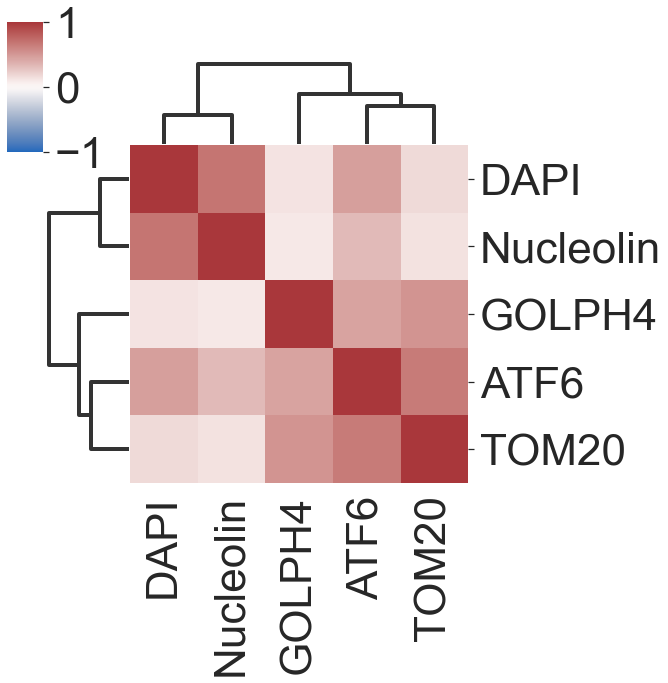

In [16]:
sns.set_style("dark")
range_list = [-1., 1.]
annot = False

df_mean = pd.DataFrame(metric_array_mean_UC, columns=channel_names_modif, index=channel_names_modif)
sns.set(font_scale = 4)
g = sns.clustermap(df_mean, vmin=range_list[0], vmax=range_list[1],  cmap='vlag', annot=annot, cbar_kws={'ticks': [-1, 0, 1]}, \
                  tree_kws=dict(linewidths=4)) 

image_path_png = save_path + "/average_pearson_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

### BM and UC cells combined

In [17]:
def marker_list_2_pair(marker_1_list, marker_2_list, dict_marker_organelle=dict_marker_organelle):
    list_pair = []

    for m1, m2 in zip(marker_1_list, marker_2_list):
        list_pair.append(f"{m1}_{m2}")
            
    return(list_pair)

In [18]:
list_pair_modif = []

for i in range(len(channel_names_modif)):
    for j in range(i):
        list_pair_modif.append(f"{channel_names_modif[i]}_{channel_names_modif[j]}")

In [19]:
def ravel_without_diag(matrix):
    M, N = matrix.shape
    ravel_list = []
    marker_1_list = []
    marker_2_list = []
    for i in range(M):
        for j in range(i):
            ravel_list.append(matrix[i][j])
            marker_1_list.append(channel_names_modif[i])
            marker_2_list.append(channel_names_modif[j])
    return([np.array(ravel_list), np.array(marker_1_list), np.array(marker_2_list)])

In [20]:
df_metric = pd.DataFrame()
cell_type_label = []
c = 1
for cell in trange(len(metric_array_list_BM)):
    for i in range(1): 
        diag_temp, marker_1_list, marker_2_list = ravel_without_diag(metric_array_list_BM[cell])
        df_metric_temp = pd.DataFrame(diag_temp, columns=['Value'])
        df_metric_temp['Cell Type'] = 'BM'
        df_metric_temp['Cell'] = cell + 1
        df_metric_temp['Cell number'] = c
        df_metric_temp['Marker1'] = marker_1_list
        df_metric_temp['Marker2'] = marker_2_list
        list_pair = marker_list_2_pair(marker_1_list, marker_2_list)
        df_metric_temp['Marker pair'] = list_pair
        df_metric = pd.concat([df_metric, df_metric_temp], axis=0)
    c += 1
    cell_type_label.append('BM')
for cell in trange(len(metric_array_list_UC)):
    for i in range(1): 
        diag_temp, marker_1_list, marker_2_list = ravel_without_diag(metric_array_list_UC[cell])
        df_metric_temp = pd.DataFrame(diag_temp, columns=['Value'])
        df_metric_temp['Cell Type'] = 'UC'
        df_metric_temp['Cell'] = cell + 1
        df_metric_temp['Cell number'] = c
        df_metric_temp['Marker1'] = marker_1_list
        df_metric_temp['Marker2'] = marker_2_list
        list_pair = marker_list_2_pair(marker_1_list, marker_2_list)
        df_metric_temp['Marker pair'] = list_pair
        df_metric = pd.concat([df_metric, df_metric_temp], axis=0)
    c += 1
    cell_type_label.append('UC')

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
df_metric_temp = df_metric[df_metric['Marker pair'].isin(list_pair_modif)]
df_metric_temp

,Value,Cell Type,Cell,Cell number,Marker1,Marker2,Marker pair
0,0.196423,BM,1,1,DAPI,ATF6,DAPI_ATF6
1,0.886905,BM,1,1,GOLPH4,ATF6,GOLPH4_ATF6
2,0.258731,BM,1,1,GOLPH4,DAPI,GOLPH4_DAPI
3,0.163510,BM,1,1,Nucleolin,ATF6,Nucleolin_ATF6
4,0.900525,BM,1,1,Nucleolin,DAPI,Nucleolin_DAPI
...,...,...,...,...,...,...,...
5,-0.000618,UC,7,14,Nucleolin,GOLPH4,Nucleolin_GOLPH4
6,0.621493,UC,7,14,TOM20,ATF6,TOM20_ATF6
7,0.108850,UC,7,14,TOM20,DAPI,TOM20_DAPI
8,0.439772,UC,7,14,TOM20,GOLPH4,TOM20_GOLPH4


  0%|          | 0/1 [00:00<?, ?it/s]

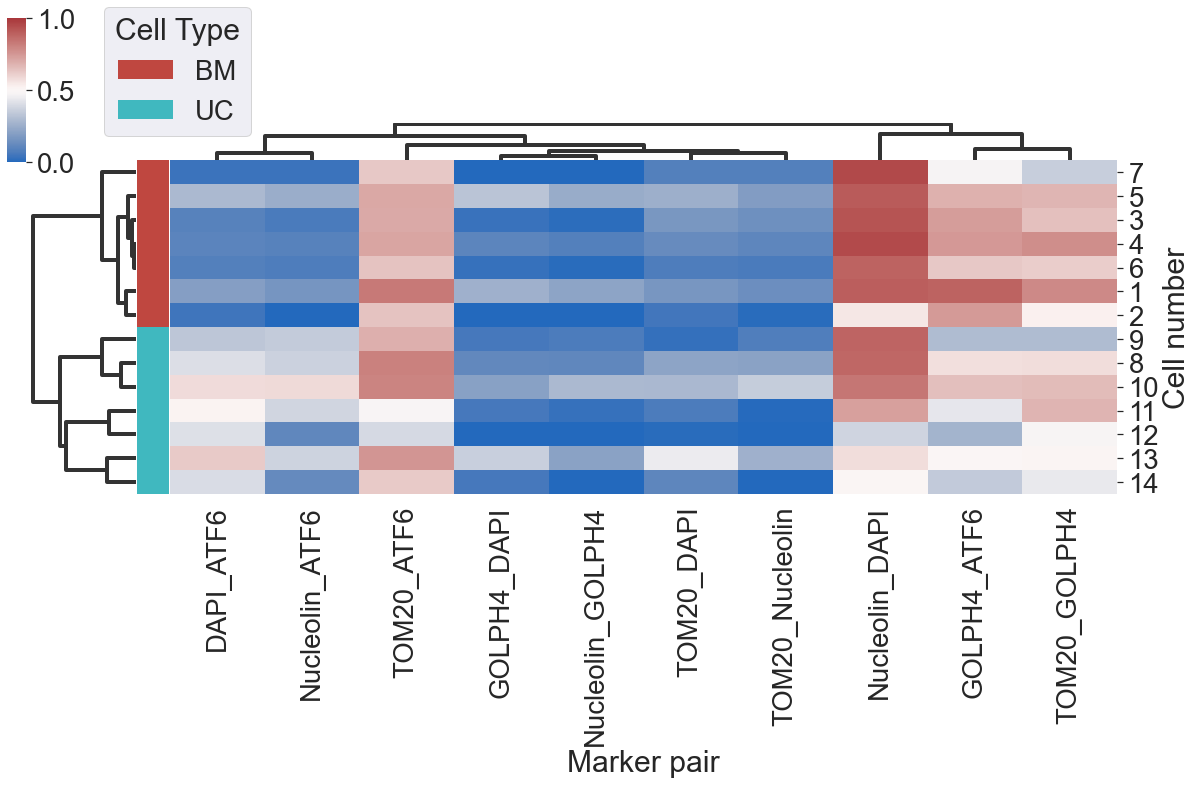

In [29]:
metric_list = [
    'correlation',
]

data = df_metric_temp
x = 'Marker pair'
y = 'Cell number'
values = 'Value'
range_list = [0, 1]
data_pivot = data.pivot(index=y, columns=x, values=values)
data_pivot = data_pivot.loc[:, list_pair_modif]

lut1 = dict(zip(['BM', 'UC'], sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    sns.set(font_scale = 2.5)
    g=sns.clustermap(data_pivot, 
                     figsize=(17, 10),
                     vmin=range_list[0], 
                     vmax=range_list[1],
                     row_colors=[row_colors1], 
                     yticklabels=True, 
                     cbar_pos=(0.01, 0.9, 0.015, .2),
                     metric=metric_temp,
                     dendrogram_ratio=(0.1, 0.1),
                    cmap='vlag', \
                    tree_kws=dict(linewidths=4))

    for label in np.unique(np.array(cell_type_label, dtype=object)):
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper right", bbox_to_anchor=(0.1, 4.5))
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

    image_path_png = save_path + "/pairwise_clustered_"+str(metric_temp)+".png"
    g.savefig(image_path_png, bbox_inches="tight")
    plt.show()